In [ ]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
import os, shutil

os.makedirs("HAM10000_images", exist_ok=True)

for part in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
    for file in os.listdir(part):
        shutil.move(os.path.join(part, file), "HAM10000_images")

In [ ]:
# ==============================
# STEP 2: Merge Images Into One Folder
# ==============================
import os, shutil

os.makedirs("HAM10000_images", exist_ok=True)

for part in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
    for file in os.listdir(part):
        shutil.move(os.path.join(part, file), "HAM10000_images")

In [ ]:
# ==============================
# STEP 3: Load Metadata & Prepare Labels
# ==============================
import pandas as pd

df = pd.read_csv("HAM10000_metadata.csv")
df['image_path'] = df['image_id'].apply(lambda x: os.path.join("HAM10000_images", x + ".jpg"))

label_names = df['dx'].unique().tolist()
label_to_index = {name: idx for idx, name in enumerate(label_names)}
df['label_idx'] = df['dx'].map(label_to_index)

print("Label mapping:", label_to_index)
df.head()

Label mapping: {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                         image_path  label_idx  
0  HAM10000_images/ISIC_0027419.jpg          0  
1  HAM10000_images/ISIC_0025030.jpg          0  
2  HAM10000_images/ISIC_0026769.jpg          0  
3  HAM10000_images/ISIC_0025661.jpg          0  
4  HAM10000_images/ISIC_0031633.jpg          0

In [ ]:
# ==============================
# STEP 4: Train/Val/Test Split
# ==============================
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label_idx'], random_state=42)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 6409 Val: 1603 Test: 2003


In [ ]:
# ==============================
# STEP 5: TF Dataset Pipeline
# ==============================
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

def make_dataset(dataframe, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['image_path'].values, dataframe['label_idx'].values))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df, shuffle=False)
test_ds = make_dataset(test_df, shuffle=False)

In [ ]:
from tensorflow.keras import layers, models

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,831 (24.86 MB)

 Trainable params: 6,517,831 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
label_fullname = {
    'akiec': 'Actinic Keratoses (akiec)',
    'bcc':   'Basal Cell Carcinoma (bcc)',
    'bkl':   'Benign Keratosis (bkl)',
    'df':    'Dermatofibroma (df)',
    'mel':   'Melanoma (mel)',
    'nv':    'Melanocytic Nevi (nv)',
    'vasc':  'Vascular Lesions (vasc)'
}

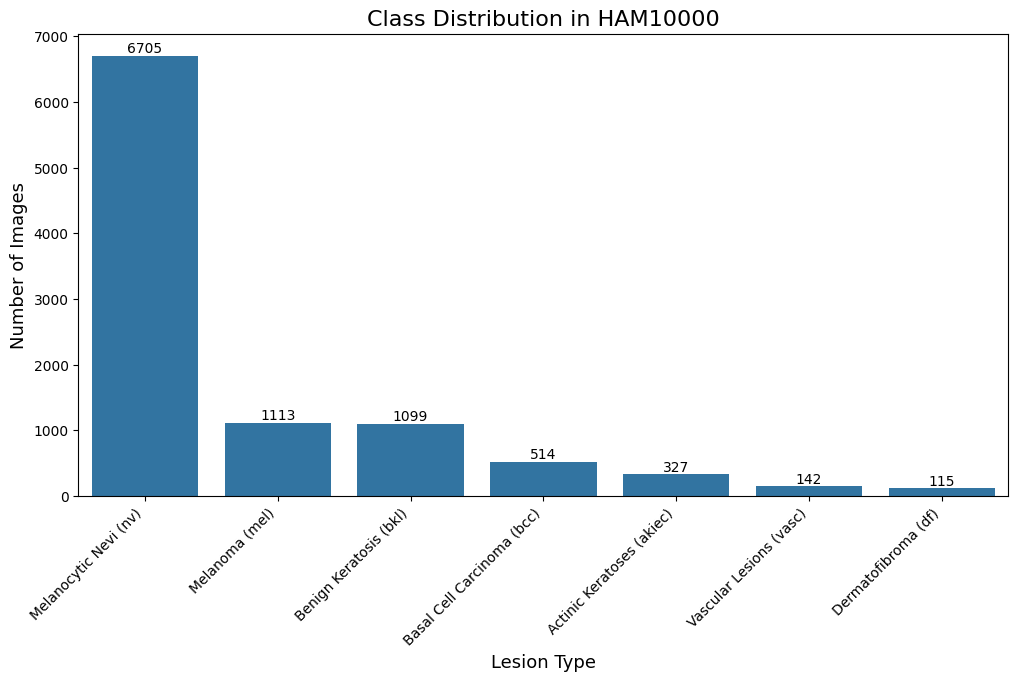

In [ ]:
df['dx_full'] = df['dx'].map(label_fullname)

import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['dx_full'].value_counts()

plt.figure(figsize=(12,6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values)

for i, v in enumerate(class_counts.values):
    ax.text(i, v + 50, str(v), ha='center', fontsize=10)

plt.title("Class Distribution in HAM10000", fontsize=16)
plt.xlabel("Lesion Type", fontsize=13)
plt.ylabel("Number of Images", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.show()

/tmp/ipython-input-459714370.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_samples = df[df['dx'].isin(selected_classes)].groupby('dx').apply(lambda x: x.sample(1)).reset_index(drop=True)


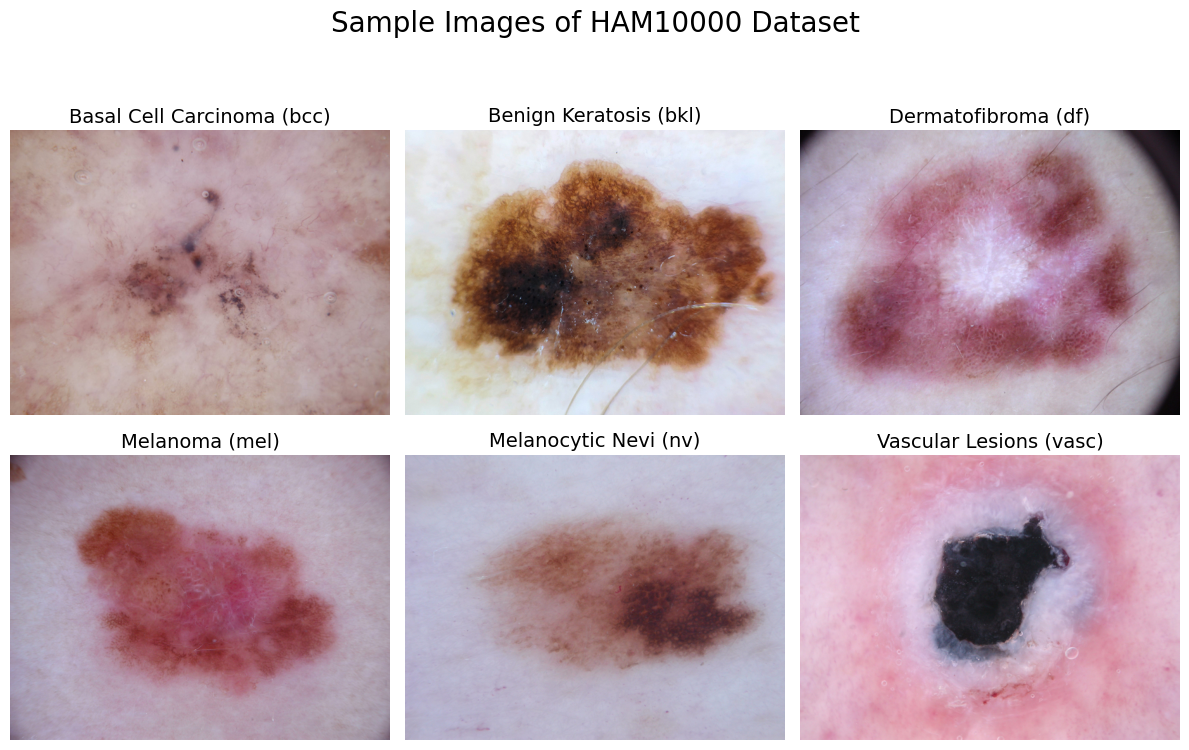

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Select 6 unique classes (HAM10000 has 7 classes, so pick any 6)
selected_classes = df['dx'].unique()[:6]

balanced_samples = df[df['dx'].isin(selected_classes)].groupby('dx').apply(lambda x: x.sample(1)).reset_index(drop=True)

plt.figure(figsize=(12, 8))

for i, row in enumerate(balanced_samples.itertuples()):
    img = cv2.imread(row.image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(label_fullname[row.dx], fontsize=14)  # Full name + short form
    plt.axis("off")

plt.suptitle("Sample Images of HAM10000 Dataset", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
percentage_dist = df['dx_full'].value_counts(normalize=True) * 100

print("Percentage Distribution (%):\n")
print(percentage_dist.round(4))


Percentage Distribution (%):

dx_full
Melanocytic Nevi (nv)         66.9496
Melanoma (mel)                11.1133
Benign Keratosis (bkl)        10.9735
Basal Cell Carcinoma (bcc)     5.1323
Actinic Keratoses (akiec)      3.2651
Vascular Lesions (vasc)        1.4179
Dermatofibroma (df)            1.1483
Name: proportion, dtype: float64


In [ ]:
# ==============================
# STEP 7: Train Model (No Early Stopping)
# ==============================

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 42s 172ms/step - accuracy: 0.6441 - loss: 1.1319 - val_accuracy: 0.6700 - val_loss: 0.9547
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.6670 - loss: 0.9735 - val_accuracy: 0.6731 - val_loss: 0.9340
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 42s 188ms/step - accuracy: 0.6666 - loss: 0.9205 - val_accuracy: 0.6868 - val_loss: 0.9745
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step - accuracy: 0.6655 - loss: 0.9331 - val_accuracy: 0.6700 - val_loss: 0.8325
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.6828 - loss: 0.8626 - val_accuracy: 0.6900 - val_loss: 0.8288
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.6860 - loss: 0.8436 - val_accuracy: 0.7006 - val_loss: 0.8349
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 38s 164ms/step - accuracy: 0.6958 - loss: 0.8161 - val_accuracy: 0.7062 - val_loss: 0.8060
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - accuracy: 0.6965 - loss: 0

In [ ]:
# ==============================
# STEP 8: Evaluate Model
# ==============================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.7621 - loss: 0.6437
✅ Test Accuracy: 0.7748, Loss: 0.6169


In [ ]:
# ==============================
# STEP 9: Classification Report & Confusion Matrix
# ==============================
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=label_names))
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━

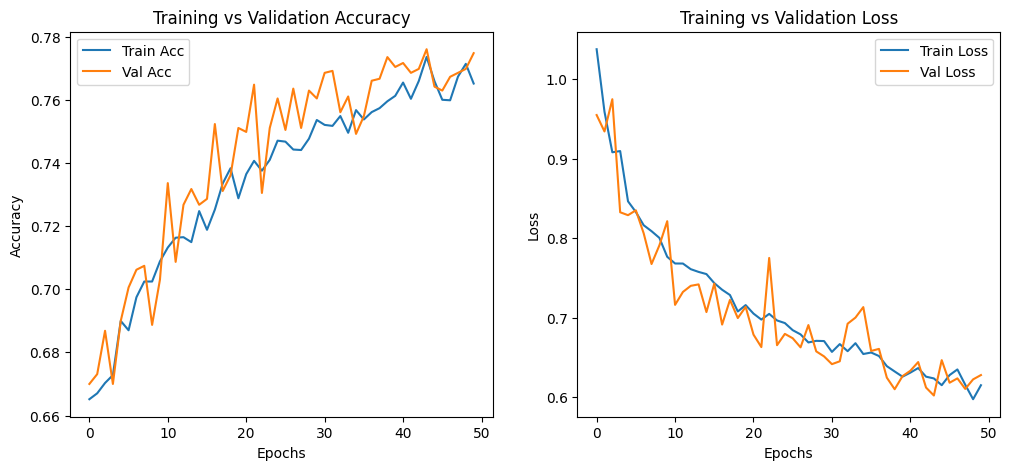

In [ ]:
# ==============================
# STEP 10: Training Curves
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()

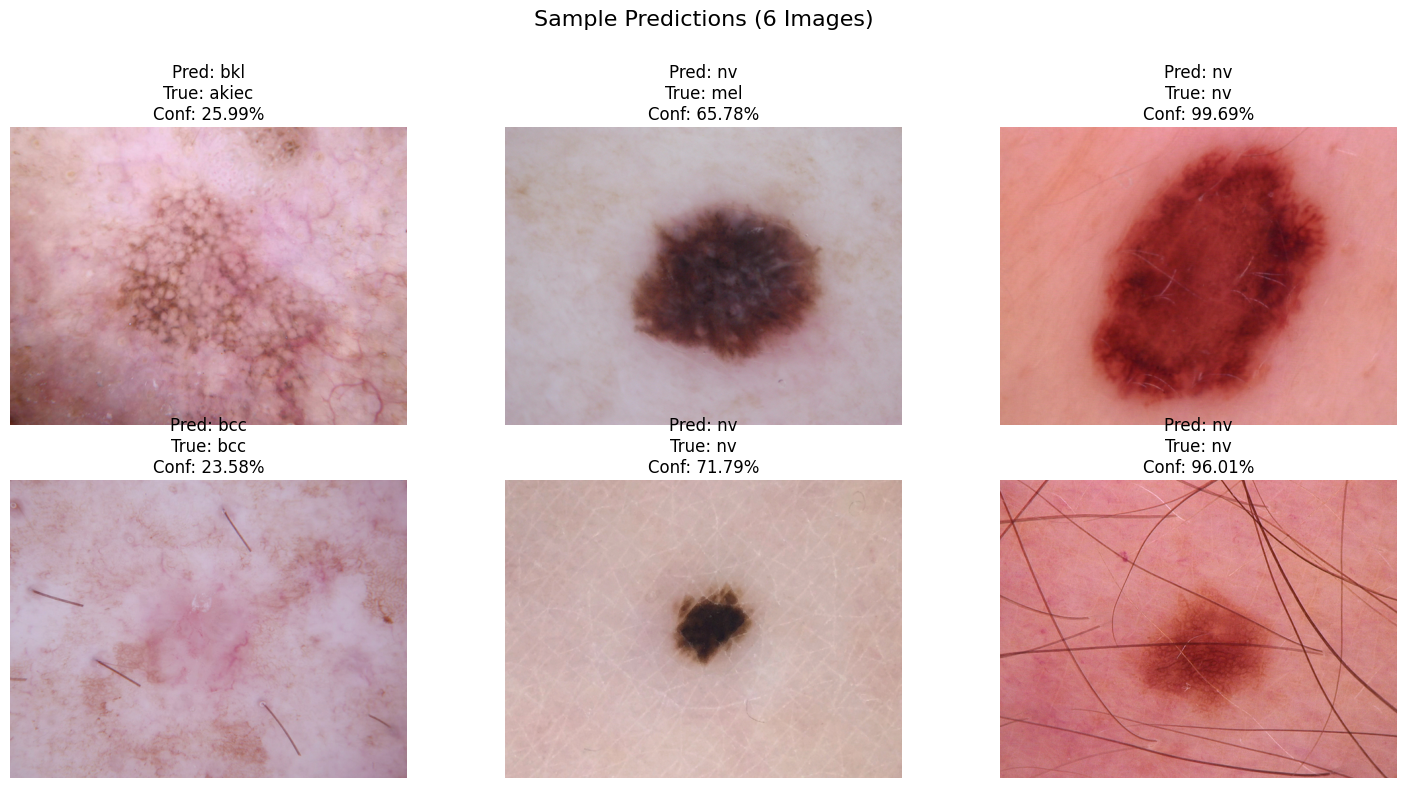

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

# Mapping index → class name
index_to_label = {v: k for k, v in label_to_index.items()}

# Pick 6 random samples from test dataframe
sample_df = test_df.sample(6)

plt.figure(figsize=(15, 8))

for i, row in enumerate(sample_df.itertuples()):
    # Load image
    img = tf.io.read_file(row.image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, IMG_SIZE)  # 128 or 224 depending on model

    # Preprocess based on model type
    if "resnet" in str(model).lower():    # If ResNet model
        img_input = preprocess_input(img_resized)
    else:                                 # For CNN model
        img_input = img_resized / 255.0

    # Add batch dimension
    img_input = tf.expand_dims(img_input, 0)

    # Predict
    pred = model.predict(img_input, verbose=0)
    pred_label_idx = tf.argmax(pred, axis=1).numpy()[0]
    pred_label = index_to_label[pred_label_idx]
    confidence = np.max(pred) * 100

    # True label
    true_label = row.dx

    # Plot
    plt.subplot(2, 3, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}\nConf: {confidence:.2f}%", fontsize=12)
    plt.axis("off")

plt.suptitle("Sample Predictions (6 Images)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)     # RESNET PREPROCESSING
    return img, label

def make_dataset(dataframe, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (dataframe['image_path'].values, dataframe['label_idx'].values)
    )
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df, shuffle=False)
test_ds = make_dataset(test_df, shuffle=False)


In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

# Freeze base model layers
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 80s 308ms/step - accuracy: 0.6520 - loss: 1.1296 - val_accuracy: 0.7392 - val_loss: 0.7387
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 311ms/step - accuracy: 0.7264 - loss: 0.7900 - val_accuracy: 0.7436 - val_loss: 0.7676
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 71s 263ms/step - accuracy: 0.7270 - loss: 0.7417 - val_accuracy: 0.7598 - val_loss: 0.6465
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 67s 309ms/step - accuracy: 0.7490 - loss: 0.6961 - val_accuracy: 0.7823 - val_loss: 0.6130
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 67s 308ms/step - accuracy: 0.7608 - loss: 0.6594 - val_accuracy: 0.7648 - val_loss: 0.6558
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 259ms/step - accuracy: 0.7685 - loss: 0.6403 - val_accuracy: 0.7642 - val_loss: 0.6281
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 58s 258ms/step - accuracy: 0.7613 - loss: 0.6437 - val_accuracy: 0.7642 - val_loss: 0.6669
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 80s 244ms/step - accuracy: 0.7746 - loss: 0

In [ ]:
# ==============================
# STEP 8: Evaluate Model
# ==============================
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - accuracy: 0.8089 - loss: 0.7412
✅ Test Accuracy: 0.8043, Loss: 0.7698


In [ ]:
# ==============================
# STEP 9: Classification Report & Confusion Matrix
# ==============================
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=label_names))
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

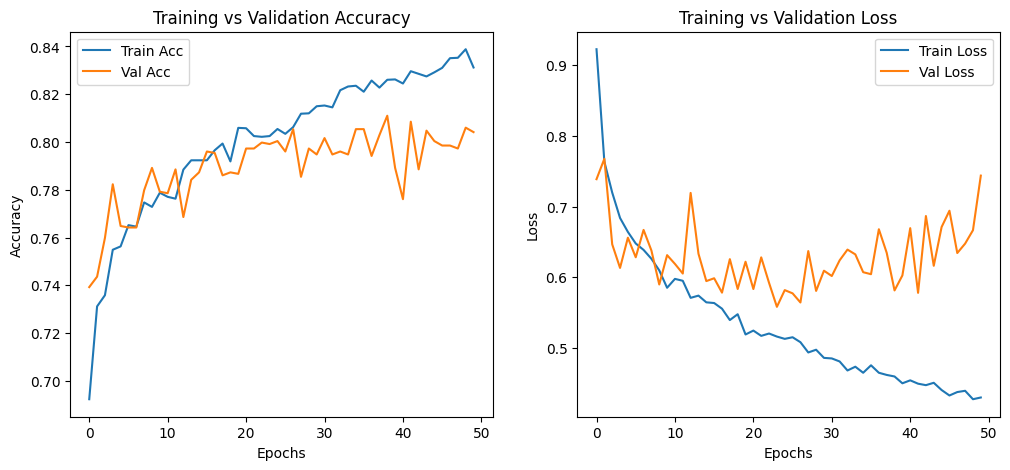

In [ ]:
# ==============================
# STEP 10: Training Curves
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()

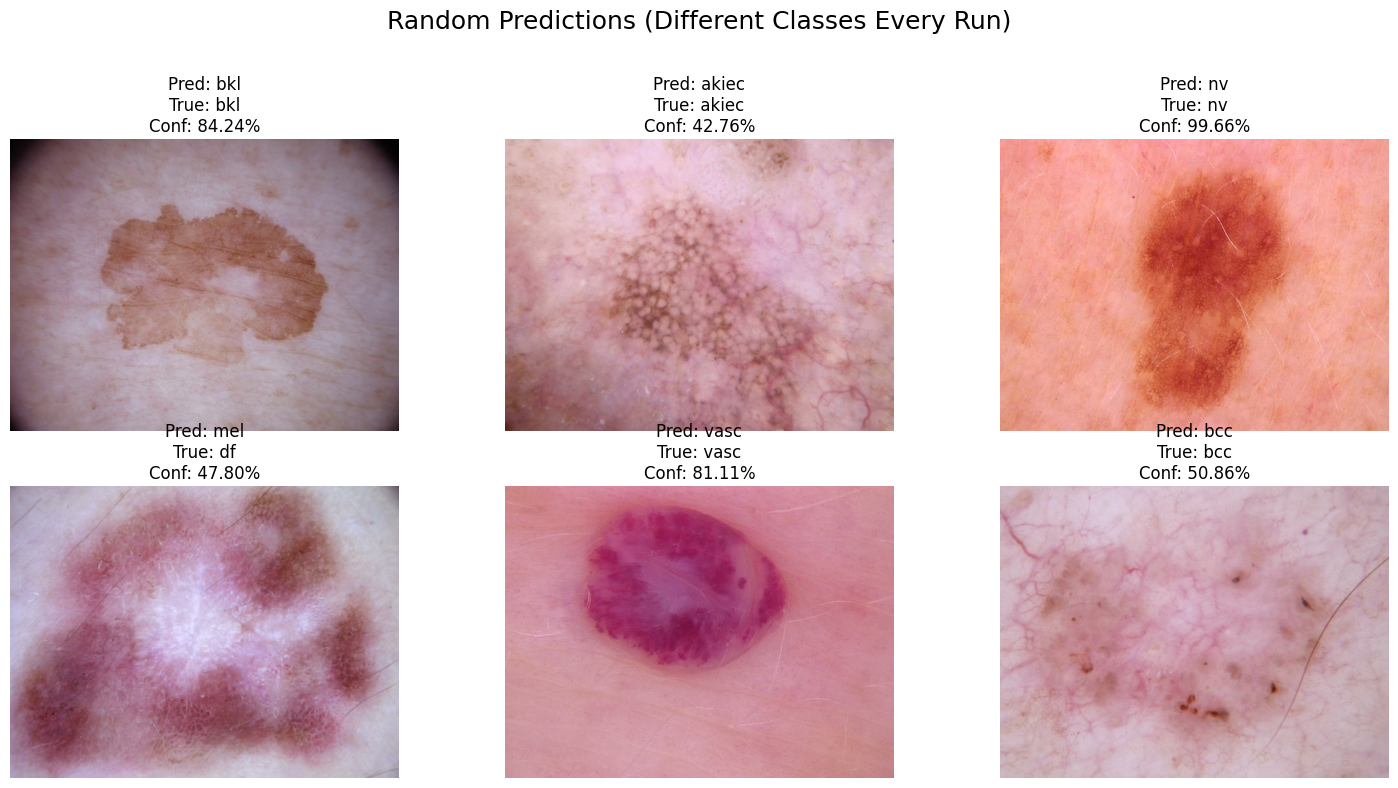

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

# Reverse mapping
index_to_label = {v: k for k, v in label_to_index.items()}

# Pick 6 random classes each time
all_classes = df['dx'].unique().tolist()
selected_classes = random.sample(all_classes, 6)

# Get 1 random image for each selected class
sample_list = []
for cls in selected_classes:
    cls_df = test_df[test_df['dx'] == cls]
    if len(cls_df) > 0:
        sample_list.append(cls_df.sample(1))

sample_df = pd.concat(sample_list)

plt.figure(figsize=(15, 8))

for i, row in enumerate(sample_df.itertuples()):
    img = tf.io.read_file(row.image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, IMG_SIZE)

    # Auto-detect preprocessing (ResNet uses preprocess_input)
    try:
        img_input = preprocess_input(img_resized)  # ResNet
    except:
        img_input = img_resized / 255.0            # CNN

    img_input = tf.expand_dims(img_input, 0)

    # Prediction
    pred = model.predict(img_input, verbose=0)
    pred_idx = tf.argmax(pred, axis=1).numpy()[0]
    pred_label = index_to_label[pred_idx]
    confidence = np.max(pred) * 100

    true_label = row.dx

    plt.subplot(2, 3, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}\nConf: {confidence:.2f}%", fontsize=12)
    plt.axis("off")

plt.suptitle("Random Predictions (Different Classes Every Run)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
